# RF regression on sequence features with post‑hoc calibration
Minimal, readable pipeline split into cells.

## 1) Imports & config

In [57]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    from scipy.interpolate import PchipInterpolator
    _HAVE_PCHIP = True
except Exception:
    _HAVE_PCHIP = False

INFILE = "merged_output_balanced_2.csv"   # must contain columns: sequence, LogGFP
SEQ_COL = "sequence"
LABEL_COL = "LogGFP"
WINDOW = ("central", 6, 24)                  # ("all",0,0) or ("span", start, end)
TEST_SIZE = 0.20
SEED = 123
OUT = "seq_rf"

RF_PARAMS = dict(
    n_estimators=1000,
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
)


## 2) Utilities: one‑hot featurizer


onehot_positional	Converts each DNA sequence into a one-hot encoded numeric array (mononucleotide level)	DataFrame of 0s and 1s
Model trains on:	The frequency/pattern of each nucleotide (A/C/G/T) at each specific positio.Global features (cheap, effective):
GC fraction
length
longest poly-A and poly-T run (captures homopolymers)
k-mer features (richer sequence context):
Frequencies of observed k-mers for chosen k (e.g., 2 or 3)
Normalized by the number of windows (len(seq) - k + 1

In [58]:
def build_X(
    df: pd.DataFrame,
    window=WINDOW,          # ("all",0,0) or ("span", start, end)
    kmer_ks=(2,3),
    collapse_rc=True,
    add_global=True
) -> pd.DataFrame:
    import numpy as np, pandas as pd
    from itertools import product

    NUCS = "ACGT"
    seqs = df[SEQ_COL].astype(str).str.upper().str.replace("U","T", regex=False)
    seqs = seqs.map(lambda s: ''.join(ch for ch in s if ch in NUCS))

    # window
    if window[0] == "all":
        L = seqs.str.len().min()
        start, end = 0, L-1
    else:
        _, start, end = window

    # positional mono one-hot
    cols = [f"pos{p}_{n}" for p in range(start, end+1) for n in NUCS]
    Xpos = np.zeros((len(seqs), (end-start+1)*4), float)
    for i,s in enumerate(seqs):
        s = (s + "N"*(end+1-len(s)))[:end+1]
        for p in range(start, end+1):
            b = s[p]
            if b in NUCS:
                Xpos[i, (p-start)*4 + NUCS.index(b)] = 1.0
    frames = [pd.DataFrame(Xpos, columns=cols, index=df.index)]

    # globals
    if add_global:
        def longest_run(s, base):
            m = c = 0
            for ch in s:
                if ch == base: c += 1; m = max(m,c)
                else: c = 0
            return m
        g = pd.DataFrame(index=df.index)
        g["gc_frac"]   = seqs.map(lambda s: 0.0 if len(s)==0 else (s.count("G")+s.count("C"))/len(s))
        g["length"]    = seqs.map(len)
        g["max_polyA"] = seqs.map(lambda s: longest_run(s,"A"))
        g["max_polyT"] = seqs.map(lambda s: longest_run(s,"T"))
        frames.append(g)

    # k-mer freqs
    if kmer_ks:
        def rc(s): return s.translate(str.maketrans("ACGT","TGCA"))[::-1]
        vocab = []
        for k in kmer_ks:
            base = [''.join(t) for t in product(NUCS, repeat=k)]
            if collapse_rc:
                seen=set(); kept=[]
                seen=set(); kept=[]
                for km in base:
                    key = min(km, rc(km))
                    if key not in seen: seen.add(key); kept.append(key)
                base = kept
            vocab += [(k, km) for km in base]
        mat = np.zeros((len(seqs), len(vocab)), float)
        for i,s in enumerate(seqs):
            for j,(k,km) in enumerate(vocab):
                if len(s) >= k:
                    denom = len(s) - k + 1
                    mat[i,j] = sum(1 for t in range(denom) if s[t:t+k]==km)/denom
        frames.append(pd.DataFrame(mat, columns=[f"{k}mer_{km}" for k,km in vocab], index=df.index))

    # no imputer/variance filter here
    return pd.concat(frames, axis=1)


2) Split → train-only filtering + imputation

In [59]:
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

# 1) Load & filter
df = pd.read_csv(INFILE)


X = build_X(df)
y = pd.to_numeric(df[LABEL_COL], errors="coerce").to_numpy()


# 80/20 with finer stratification
bins = pd.qcut(pd.Series(y), q=30, labels=False, duplicates="drop")
Xtr, Xte, ytr, yte = train_test_split(
    X, y, train_size=0.80, test_size=0.20,
    random_state=SEED, stratify=bins
)



# drop near-constant features using TRAIN ONLY
var_mask = Xtr.var(ddof=0) > 1e-12
Xtr = Xtr.loc[:, var_mask]
Xte = Xte.loc[:, var_mask.index[var_mask]]

# impute using TRAIN ONLY
imp = SimpleImputer(strategy="mean")
Xtr = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)


3) Weights + fit (asymmetric tails)

In [60]:
def band_weights_5(y, qcuts=(0.15, 0.35, 0.60, 0.85),
                   w=(10.0, 4.0, 1.0, 4.0, 10.0),
                   normalize=True):
    y = np.asarray(y, float)
    q1, q2, q3, q4 = np.quantile(y, qcuts)

    wv = np.full_like(y, w[2], dtype=float)       # middle band
    wv[y <= q1] = w[0]                            # very low
    wv[(y > q1) & (y <= q2)] = w[1]               # low
    wv[(y > q2) & (y <= q3)] = w[2]               # mid
    wv[(y > q3) & (y <= q4)] = w[3]               # high
    wv[y > q4] = w[4]                             # very high

    if normalize and wv.mean() > 0:
        wv /= wv.mean()
    return wv


## 4) Train, calibrate, evaluate

In [61]:
# ---------- drop-in: clean split + weights + no-leak calibration ----------

from sklearn.model_selection import train_test_split, KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.impute import SimpleImputer
import numpy as np, pandas as pd

# 1) Load & filter
df = pd.read_csv(INFILE)
#df = pd.read_csv("merged_output_balanced.csv")
df = df[df[LABEL_COL] > 1.2].reset_index(drop=True)

# 2) Features (ensure build_X does NOT impute; we impute AFTER the split)
X = build_X(df)
y = pd.to_numeric(df[LABEL_COL], errors="coerce").to_numpy()

# 3) Make 20-bin quantile strata (safe fallback if qcut errors)
def make_strata(y, Q=20):
    for q in range(Q, 5, -1):  # try 20 down to 6
        try:
            return pd.qcut(pd.Series(y), q=q, labels=False, duplicates="drop")
        except Exception:
            continue
    return None

bins = make_strata(y, Q=20)

# 4) 80/20 split (stratified if bins worked)
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED,
    stratify=bins if bins is not None else None
)

# 5) Train-only variance filter + imputer (prevents leakage)
var_mask = Xtr.var(ddof=0) > 1e-12
Xtr = Xtr.loc[:, var_mask]
Xte = Xte.loc[:, var_mask.index[var_mask]]

imp = SimpleImputer(strategy="mean")
Xtr = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)



#rf.fit(Xtr, ytr, sample_weight=wtr)
#rf.fit(Xtr, ytr, sample_weight=wtr)
rf_unw = RandomForestRegressor(random_state=SEED, n_jobs=-1, **RF_PARAMS).fit(Xtr, ytr)
rf_w   = RandomForestRegressor(random_state=SEED, n_jobs=-1, **RF_PARAMS).fit(Xtr, ytr, sample_weight=wtr)
print("Train R² unweighted:", r2_score(ytr, rf_unw.predict(Xtr)))
print("Train R² weighted:",   r2_score(ytr, rf_w.predict(Xtr)))


# 7) Model: define ONCE, fit ONCE with weights
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1, **RF_PARAMS)
rf.fit(Xtr, ytr, sample_weight=wtr)



Train R² unweighted: 0.8797350547580445
Train R² weighted: 0.8983073832603964


,n_estimators,1000
,criterion,'squared_error'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [62]:
# 8) Predictions
yhat_tr  = rf.predict(Xtr)
yhat_raw = rf.predict(Xte)

# 9) No-leak calibrator: OOF isotonic on train predictions
import numpy as np
from sklearn.model_selection import KFold
from sklearn.isotonic import IsotonicRegression

def fit_calibrator_oof_pred(y_pred_train, y_train, n_splits=5, seed=123):
    """
    Fit isotonic regression on TRAIN ONLY using K-fold OOF predictions
    and return a ('iso', fitted_model) tuple suitable for saving.
    """
    y_pred_train = np.asarray(y_pred_train, float)
    y_train      = np.asarray(y_train, float)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.empty_like(y_train, float)

    for tr, va in kf.split(y_pred_train):
        iso_k = IsotonicRegression(increasing=True, out_of_bounds="clip")
        iso_k.fit(y_pred_train[tr], y_train[tr])
        oof[va] = iso_k.predict(y_pred_train[va])

    # final calibrator refit on *all* train data
    iso = IsotonicRegression(increasing=True, out_of_bounds="clip")
    iso.fit(y_pred_train, y_train)
    return ("iso", iso)

def apply_calibrator(y_pred, calibrator):
    """
    Apply a saved calibrator tuple to predictions.
    Supports ('iso', model) and ('qmap', {'xp':..., 'fp':...}).
    """
    kind, obj = calibrator
    y_pred = np.asarray(y_pred, float)
    if kind == "iso":
        return obj.predict(y_pred)
    elif kind == "qmap":
        return np.interp(y_pred, obj["xp"], obj["fp"])
    else:
        return y_pred  # no-op fallback


# 10) Metrics
# Ensure we have test preds in `yhat`
if 'yhat' not in locals():
    if 'yhat_te' in locals():
        yhat = yhat_te
    else:
        # fall back: compute now
        s_te = rf.predict(Xte)
        try:
            yhat = apply_calibrator(s_te, calib)  # if you use calibration
        except Exception:
            yhat = s_te

assert 'yte' in locals(), "yte not defined"
assert len(yhat) == len(yte), "Pred/true length mismatch"

r2   = r2_score(yte, yhat)
rmse = mean_squared_error(yte, yhat) ** 0.5
mae  = mean_absolute_error(yte, yhat)
print(f"R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

R²=0.834 | RMSE=0.135 | MAE=0.103


## 5) Plots & saving predictions

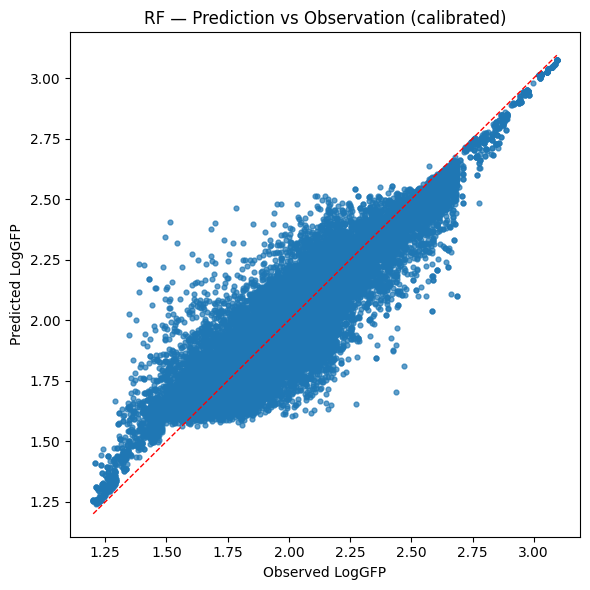

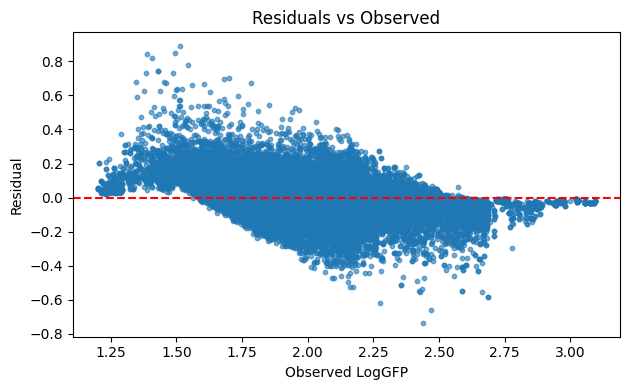

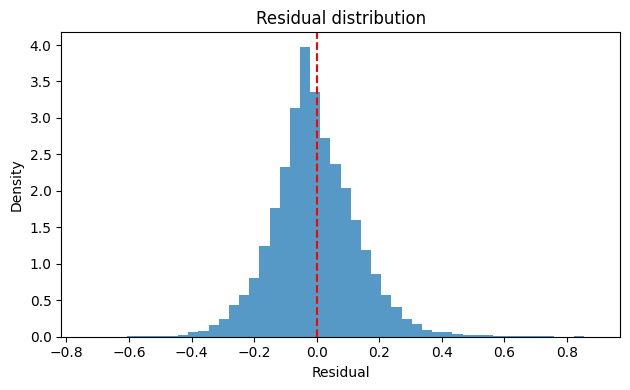

In [63]:
def show_and_save(fig, name):
    fig.tight_layout(); fig.savefig(f"{OUT}_{name}.png", dpi=300); plt.show(); plt.close(fig)

fig = plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, s=12, alpha=0.7)
lo,hi = float(min(yte.min(),yhat.min())), float(max(yte.max(),yhat.max()))
plt.plot([lo,hi],[lo,hi],'r--',lw=1)
plt.xlabel("Observed LogGFP"); plt.ylabel("Predicted LogGFP")
plt.title("RF — Prediction vs Observation (calibrated)")
show_and_save(fig, "pred_vs_obs")

res = yhat - yte
fig = plt.figure(figsize=(6.4,4))
plt.scatter(yte,res,s=10,alpha=0.6); plt.axhline(0, color='r', ls='--')
plt.xlabel("Observed LogGFP"); plt.ylabel("Residual")
plt.title("Residuals vs Observed")
show_and_save(fig, "residuals_vs_obs")

fig = plt.figure(figsize=(6.4,4))
plt.hist(res, bins=50, density=True, alpha=0.75)
plt.axvline(0, color='r', ls='--'); plt.xlabel("Residual"); plt.ylabel("Density")
plt.title("Residual distribution")
show_and_save(fig, "residual_hist")

pd.DataFrame({"y_true":yte, "y_pred_raw":yhat_raw, "y_pred":yhat}).to_csv(f"{OUT}_preds.csv", index=False)


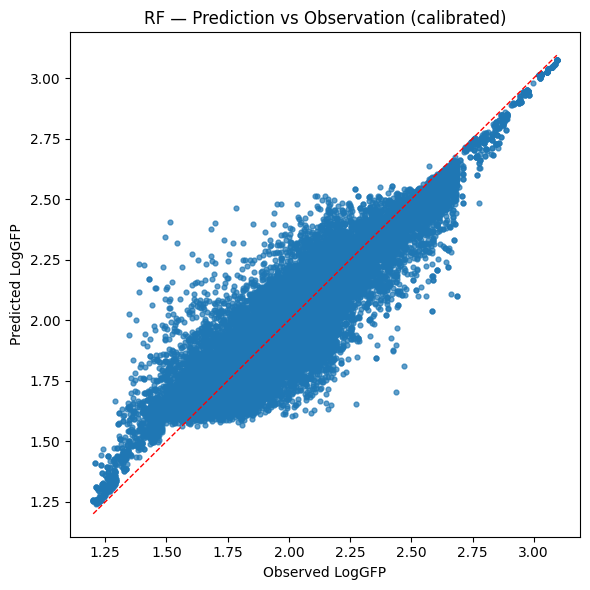

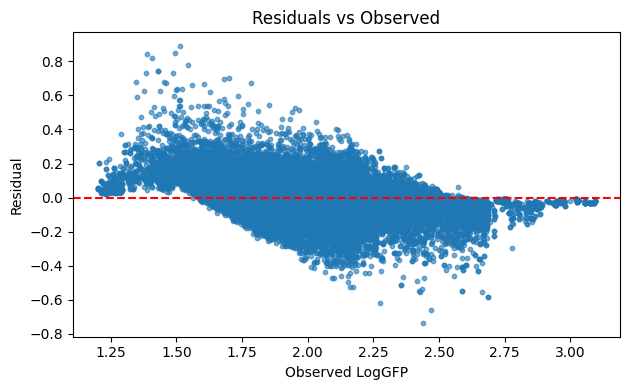

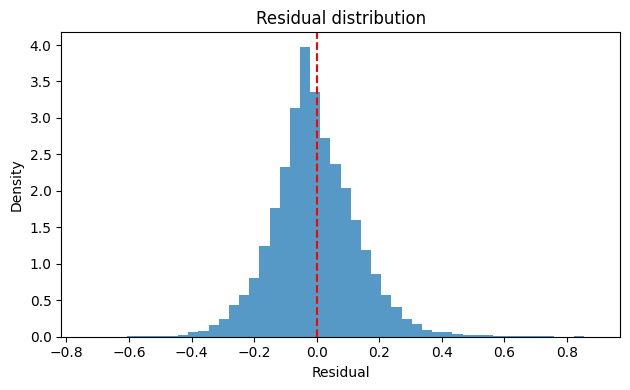

In [64]:
def show_and_save(fig, name):
    fig.tight_layout(); fig.savefig(f"{OUT}_{name}.png", dpi=300); plt.show(); plt.close(fig)

fig = plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, s=12, alpha=0.7)
lo,hi = float(min(yte.min(),yhat.min())), float(max(yte.max(),yhat.max()))
plt.plot([lo,hi],[lo,hi],'r--',lw=1)
plt.xlabel("Observed LogGFP"); plt.ylabel("Predicted LogGFP")
plt.title("RF — Prediction vs Observation (calibrated)")
show_and_save(fig, "pred_vs_obs")

res = yhat - yte
fig = plt.figure(figsize=(6.4,4))
plt.scatter(yte,res,s=10,alpha=0.6); plt.axhline(0, color='r', ls='--')
plt.xlabel("Observed LogGFP"); plt.ylabel("Residual")
plt.title("Residuals vs Observed")
show_and_save(fig, "residuals_vs_obs")

fig = plt.figure(figsize=(6.4,4))
plt.hist(res, bins=50, density=True, alpha=0.75)
plt.axvline(0, color='r', ls='--'); plt.xlabel("Residual"); plt.ylabel("Density")
plt.title("Residual distribution")
show_and_save(fig, "residual_hist")

pd.DataFrame({"y_true":yte, "y_pred_raw":yhat_raw, "y_pred":yhat}).to_csv(f"{OUT}_preds.csv", index=False)


In [65]:
print(f"Train R² = {r2_score(ytr, yhat_tr):.3f}")
print(f"Test  R² = {r2_score(yte, yhat):.3f}")


Train R² = 0.898
Test  R² = 0.834


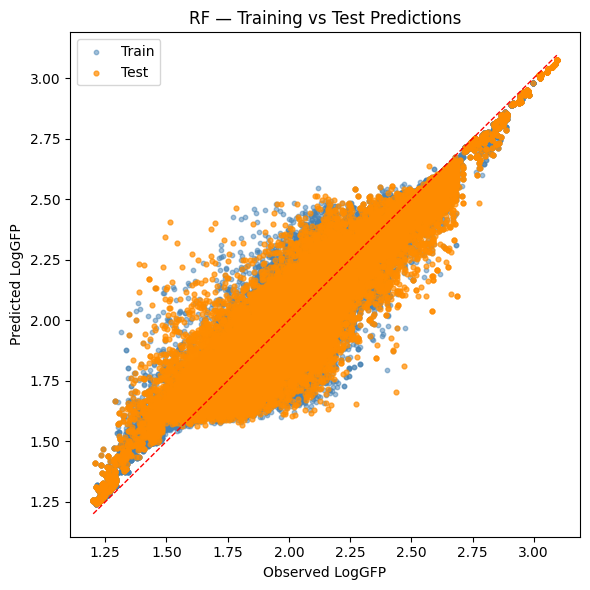

In [66]:
# --- Training vs Test prediction comparison ---
fig = plt.figure(figsize=(6,6))

# Training set (blue)
plt.scatter(ytr, yhat_tr, s=10, alpha=0.5, label="Train", color="steelblue")

# Test set (orange)
plt.scatter(yte, yhat, s=12, alpha=0.7, label="Test", color="darkorange")

# Identity line
lo, hi = float(min(y.min() for y in [ytr, yte, yhat_tr, yhat])), float(max(y.max() for y in [ytr, yte, yhat_tr, yhat]))
plt.plot([lo, hi], [lo, hi], "r--", lw=1)

plt.xlabel("Observed LogGFP")
plt.ylabel("Predicted LogGFP")
plt.title("RF — Training vs Test Predictions")
plt.legend()
show_and_save(fig, "train_vs_test")


Blue points (Train): predictions on your training data (ytr vs yhat_tr)
Orange points (Test): predictions on your held-out test data (yte vs yhat)
Red dashed line: ideal line where Predicted = Observed

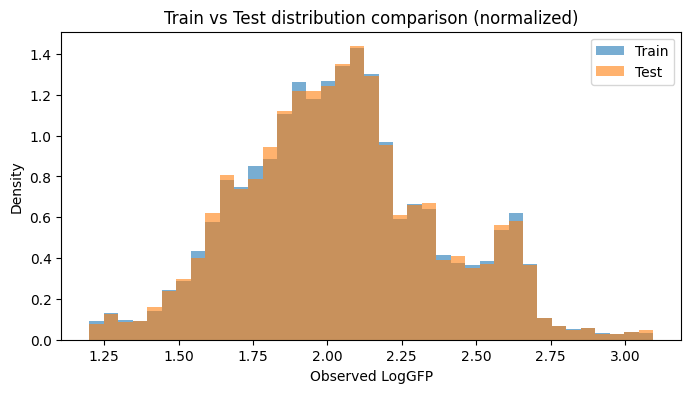

In [67]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(y.min(), y.max(), 40)  # same bins for both

plt.figure(figsize=(8, 4))
plt.hist(ytr, bins=bins, density=True, alpha=0.6, label="Train")
plt.hist(yte, bins=bins, density=True, alpha=0.6, label="Test")
plt.xlabel("Observed LogGFP")
plt.ylabel("Density")
plt.title("Train vs Test distribution comparison (normalized)")
plt.legend()
plt.show()


see the distribution

78324 19582 4.0
Middle counts 1.90–2.00: train= 9591 test= 2388


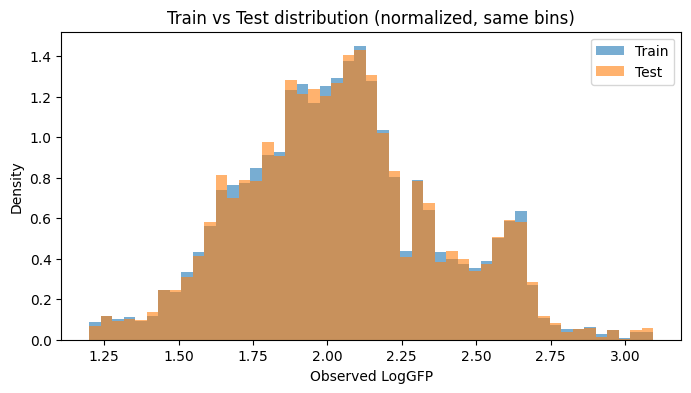

Train quantiles:
 0.0    1.201
0.1    1.636
0.2    1.763
0.3    1.868
0.4    1.949
0.5    2.031
0.6    2.104
0.7    2.180
0.8    2.318
0.9    2.545
1.0    3.094
dtype: float64

Test quantiles:
 0.0    1.201
0.1    1.636
0.2    1.763
0.3    1.868
0.4    1.949
0.5    2.031
0.6    2.104
0.7    2.180
0.8    2.318
0.9    2.545
1.0    3.094
dtype: float64


In [68]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Confirm sizes (should be ~80/20)
print(len(ytr), len(yte), round(len(ytr)/len(yte), 3))

# 2) Count samples in the “middle” band, e.g. 1.90–2.00
mid_mask_tr = (ytr >= 1.90) & (ytr <= 2.00)
mid_mask_te = (yte >= 1.90) & (yte <= 2.00)
print("Middle counts 1.90–2.00:",
      "train=", mid_mask_tr.sum(),
      "test=",  mid_mask_te.sum())

# 3) Compare shapes with SAME bins and density (so areas match)
bins = np.linspace(y.min(), y.max(), 50)
plt.figure(figsize=(8,4))
plt.hist(ytr, bins=bins, density=True, alpha=0.6, label="Train")
plt.hist(yte, bins=bins, density=True, alpha=0.6, label="Test")
plt.xlabel("Observed LogGFP"); plt.ylabel("Density")
plt.title("Train vs Test distribution (normalized, same bins)")
plt.legend(); plt.show()

# 4) Quantile table to see coverage across the range
qs = np.linspace(0,1,11)
print("Train quantiles:\n", pd.Series(ytr).quantile(qs).round(3))
print("\nTest quantiles:\n",  pd.Series(yte).quantile(qs).round(3))


save the model

In [69]:
import joblib, json, time

# Safely grab things from the current kernel, defaulting to None when missing
CALIBRATOR     = locals().get("calib", None)            # e.g., ("iso", iso_model) or None
SEQ_FEATURIZER = locals().get("seq_featurizer", None)   # your featurizer or None

# Required bits — assert so you get a clear message if something is missing
rf        = locals().get("rf", None)        # trained regressor
imp       = locals().get("imp", None)       # SimpleImputer or None
Xtr       = locals().get("Xtr", None)       # training features DataFrame
SEQ_COL   = locals().get("SEQ_COL", "sequence")
LABEL_COL = locals().get("LABEL_COL", "logGFP")
SEED      = locals().get("SEED", 42)

assert rf  is not None,  "rf (trained model) is not defined"
assert Xtr is not None,  "Xtr (training features) is not defined"

bundle = {
    "version": "seq_rf_v1",
    "trained_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "label_col": LABEL_COL,
    "seq_col":  SEQ_COL,
    "seed": SEED,
    "rf_params": getattr(rf, "get_params", lambda: {})(),

    # columns AFTER featurization/selection (what the model expects)
    "feature_columns": list(Xtr.columns),

    # preprocessing artifacts
    "imputer": imp,                 # may be None
    "calibrator": CALIBRATOR,       # may be None
    "featurizer": SEQ_FEATURIZER,   # may be None

    # the trained model
    "model": rf,
}

joblib.dump(bundle, "seq_rf_model.joblib")
print("Saved: seq_rf_model.joblib")

# Lightweight metadata (no big objects)
meta = {
    k: (v if isinstance(v, (str,int,float,bool,tuple,list,dict)) else str(type(v)))
    for k,v in bundle.items()
    if k not in ["imputer","model","calibrator","featurizer"]
}
with open("seq_rf_model.meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("Saved: seq_rf_model.meta.json")


Saved: seq_rf_model.joblib
Saved: seq_rf_model.meta.json


prediction

In [70]:
import joblib, pandas as pd, numpy as np

# load saved model
B  = joblib.load("seq_rf_model.joblib")
rf = B["model"]
imp = B.get("imputer", None)

# --- calibrator: handle None / tuple / dict ---
cal = B.get("calibrator", None)
if cal is None:
    calib_name, calib_obj = None, None
elif isinstance(cal, tuple) and len(cal) == 2:
    calib_name, calib_obj = cal
elif isinstance(cal, dict) and {"xp","fp"} <= set(cal.keys()):
    calib_name, calib_obj = "qmap", cal
else:
    raise ValueError(f"Unrecognized calibrator format: {type(cal)}")

feature_cols = B["feature_columns"]

# load your new CSV with sequences
NEW_FILE = "Up_library_features_unseen.csv"
df_new = pd.read_csv(NEW_FILE)

# rebuild features (same as training)
Xnew = build_X(
    df_new,
    window=B.get("window", ("span", 6, 24)),
    kmer_ks=B.get("kmer_ks", (2, 3)),
    collapse_rc=B.get("collapse_rc", True),
    add_global=True,
)

# align to training feature order
Xnew = Xnew.reindex(columns=feature_cols)
Xnew = Xnew.apply(pd.to_numeric, errors="coerce")

# impute if we saved an imputer; otherwise pass through
if imp is not None:
    Xnew_imp = pd.DataFrame(imp.transform(Xnew), columns=feature_cols, index=Xnew.index)
else:
    Xnew_imp = Xnew

# predict
y_raw = rf.predict(Xnew_imp).astype(float)

# calibrate if available
if calib_name == "iso":
    y_pred = calib_obj.predict(y_raw)
elif calib_name == "qmap":
    xp, fp = calib_obj["xp"], calib_obj["fp"]
    y_pred = np.interp(y_raw, xp, fp)
else:
    y_pred = y_raw  # no calibrator

# attach and save
out = df_new.copy()
out["LogGFP_pred"] = y_pred
out.to_csv("new_sequences_with_predictions.csv", index=False)
print("Saved: new_sequences_with_predictions.csv")


Saved: new_sequences_with_predictions.csv


the 6 bins, and then weakest and strongest sequnce

In [71]:
import pandas as pd
import numpy as np

# ===== 1) Input: set this to the file your previous step wrote =====
INFILE = "new_sequences_with_predictions.csv"   # <- produced by the loader
# If you saved TSV instead, use: INFILE = "seq_predictions.tsv"

# Auto-detect separator
df = pd.read_csv(INFILE, sep=None, engine="python")

# ===== 2) Identify columns =====
score_candidates = ["LogGFP_pred"]
seq_candidates   = ["sequence", "Sequence"]

score_col = next((c for c in score_candidates if c in df.columns), None)
seq_col   = next((c for c in seq_candidates   if c in df.columns), None)

assert score_col is not None, f"No prediction column found in {INFILE}. Tried {score_candidates}"
assert seq_col   is not None, f"No sequence column found in {INFILE}. Tried {seq_candidates}"

# Helper to add core19 safely
def add_core19(x: pd.DataFrame) -> pd.DataFrame:
    y = x.copy()
    y.loc[:, "core19"] = y[seq_col].astype(str).map(lambda s: s[4:-4] if len(s) >= 9 else s)
    return y

# ===== 3) Top 3 strongest =====
top3 = df.sort_values(score_col, ascending=False).head(3).copy()
top3 = add_core19(top3)
top3.to_csv("predictions_top3_4_sequence.tsv", sep="\t", index=False)

# ===== 4) Bottom 3 weakest =====
bottom3 = df.sort_values(score_col, ascending=True).head(3).copy()
bottom3 = add_core19(bottom3)
bottom3.to_csv("predictions_bottom3_4_sequence.tsv", sep="\t", index=False)

print("Wrote:")
print(" - predictions_top3_4_sequence.tsv     (strongest 3 overall)")
print(" - predictions_bottom3_4_sequence.tsv  (weakest 3 overall)")


Wrote:
 - predictions_top3_4_sequence.tsv     (strongest 3 overall)
 - predictions_bottom3_4_sequence.tsv  (weakest 3 overall)


In [6]:
import pandas as pd

df = pd.read_csv("new_sequences_with_predictions.csv")

def lookup(seq):
    print(df.loc[df["sequence"] == seq, ["sequence", "LogGFP_pred"]])

lookup("AAGGCTATATGCGGTACAGGCCTGCTT")


                         sequence  LogGFP_pred
5879  AAGGCTATATGCGGTACAGGCCTGCTT     1.616878
